## Inicjalizacja


In [74]:
from laptoppriceworkflow.data import get_json_data 
from laptoppriceworkflow.functions import clean_col_meta
from laptoppriceworkflow.functions import simplify_gwarancja
from laptoppriceworkflow.functions import simplify_komunikacja

import pandas as pd

import numpy as np

import seaborn as sns 

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [25]:
df = get_json_data()

# Partycjonowanie
Preprocessing przygotowania modelu bedzie przeprowadzany tylko na czesci treningowej 
Pozniej przepuszcze przez niego czesc testowa, ktora swtorzylem oraz dodtkowy plik bez zmiennej celu

In [26]:
msk = np.random.rand(len(df)) < 0.75
train = df[msk]
test = df[~msk]

# Wstępna Analiza

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5863 entries, 70 to 5978
Data columns (total 17 columns):
buynow_price                         5863 non-null float64
rodzaj karty graficznej              5493 non-null object
komunikacja                          5270 non-null object
rozdzielczość (piksele)              5422 non-null object
liczba rdzeni procesora              5863 non-null object
wielkość pamięci ram                 5517 non-null object
system operacyjny                    5370 non-null object
typ dysku twardego                   5542 non-null object
sterowanie                           5350 non-null object
multimedia                           5327 non-null object
typ pamięci ram                      5223 non-null object
taktowanie bazowe procesora (ghz)    5170 non-null float64
seria procesora                      5464 non-null object
stan                                 5863 non-null object
pojemność dysku (gb)                 5499 non-null float64
gwarancja          

In [5]:
train.isnull().sum()/train.shape[0]

buynow_price                         0.000000
rodzaj karty graficznej              0.063108
komunikacja                          0.101143
rozdzielczość (piksele)              0.075217
liczba rdzeni procesora              0.000000
wielkość pamięci ram                 0.059014
system operacyjny                    0.084087
typ dysku twardego                   0.054750
sterowanie                           0.087498
multimedia                           0.091421
typ pamięci ram                      0.109159
taktowanie bazowe procesora (ghz)    0.118199
seria procesora                      0.068054
stan                                 0.000000
pojemność dysku (gb)                 0.062084
gwarancja                            0.000000
wielkość matrycy                     0.043664
dtype: float64

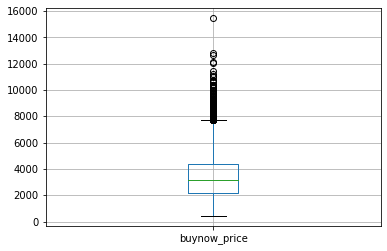

In [6]:
train.boxplot("buynow_price")

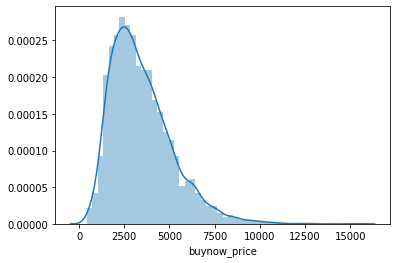

In [7]:
sns.distplot(train["buynow_price"])
plt.show()

# Budowa Preprocesingu

In [95]:
imputer = SimpleImputer(strategy = 'median')
df_num = df[['buynow_price', 'taktowanie bazowe procesora (ghz)', 'pojemność dysku (gb)']]
imputer.fit(df_num)
imputer.statistics_

array([3.149e+03, 2.500e+00, 5.000e+02])

In [80]:
X = imputer.transform(df_num)
df_num_imp = pd.DataFrame(X, columns=df_num.columns)


In [29]:
df_num_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7853 entries, 0 to 7852
Data columns (total 2 columns):
taktowanie bazowe procesora (ghz)    7853 non-null float64
pojemność dysku (gb)                 7853 non-null float64
dtypes: float64(2)
memory usage: 122.8 KB


In [30]:
encoder = LabelEncoder()
#df_cat = df[["rodzaj karty graficznej", "komunikacja","rozdzielczość (piksele)"]]
df_cat = df["liczba rdzeni procesora"]
df_cat_encoded = encoder.fit_transform(df_cat)
df_cat_encoded

array([1, 1, 1, ..., 1, 3, 1])

In [31]:
print(encoder.classes_)

['1' '2' '3' '4' '6' '8' 'nie dotyczy']


In [32]:
encoder = OneHotEncoder()
df_cat_1hot = encoder.fit_transform(df_cat_encoded.reshape(-1,1))
df_cat_1hot

<7853x7 sparse matrix of type '<class 'numpy.float64'>'
	with 7853 stored elements in Compressed Sparse Row format>

Lepsze gdy w kolumnie masz bardzo dużo kategorii i powstaje macierz rzadka (sparse matrix)
W innym przypadku lepiej LabelBinarizer() :)

In [33]:
df_cat_1hot.toarray()

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [34]:
encoder = LabelBinarizer()
df_cat_1hot = encoder.fit_transform(df_cat)
df_cat_1hot

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [86]:
#rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

rooms_ix = 3
bedrooms_ix = 4
population_ix = 5
household_ix = 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True): # żadnych zmiennych *args ani **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self # nie robi nic innego
    
    def transform(self, X, y=None):
    Pokoje_na_rodzinę = X[:, rooms_ix] / X[:, household_ix]
    Populacja_na_rodzinę = X[:, population_ix] / X[:, household_ix]
    if self.add_bedrooms_per_room:
        Sypialnie_na_pokoje = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, Pokoje_na_rodzinę, Populacja_na_rodzinę,
            Sypialnie_na_pokoje]
    else:
        return np.c_[X, Pokoje_na_rodzinę, Populacja_na_rodzinę]
    
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

IndentationError: expected an indented block (<ipython-input-86-01487d25b82e>, line 17)

In [96]:
#rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

buynow_price_ix = 0
taktowanie_bazowe_procesora_ghz_ix = 1
pojemność_dysku_gb_ix = 2
#household_ix = 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_price_per_gb = True): # żadnych zmiennych *args ani **kargs
        self.add_price_per_gb = add_price_per_gb
    
    def fit(self, X, y=None):
        return self # nie robi nic innego
    
    def transform(self, X, y=None):
        price_per_ghz = X[:, taktowanie_bazowe_procesora_ghz_ix] / X[:, buynow_price_ix]
        #Populacja_na_rodzinę = X[:, population_ix] / X[:, household_ix]
        if self.add_price_per_gb:
            price_per_gb = X[:, pojemność_dysku_gb_ix] / X[:, buynow_price_ix]
            return np.c_[X, price_per_ghz, price_per_gb]
        else:
            return np.c_[X, price_per_ghz]

In [ ]:
attr_adder = CombinedAttributesAdder(add_price_per_gb=True)
df_extra_attribs = attr_adder.transform(df.values)

In [73]:
#pd.DataFrame(df_extra_attribs, columns=df_num.columns)
pd.DataFrame(df_extra_attribs, columns = df.columns.append(pd.Index(['price_per_ghz','4242'])))


,buynow_price,rodzaj karty graficznej,komunikacja,rozdzielczość (piksele),liczba rdzeni procesora,wielkość pamięci ram,system operacyjny,typ dysku twardego,sterowanie,multimedia,typ pamięci ram,taktowanie bazowe procesora (ghz),seria procesora,stan,pojemność dysku (gb),gwarancja,wielkość matrycy,price_per_ghz,4242
0,1599,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1366 x 768,2,8 gb,[windows 10 home],hdd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,1.9,intel core i3,nowy,500,sprzedawcy,"13"" - 13.9""",0.00118824,0.312695
1,2999,grafika dedykowana,"[nfc (near field communication), gps]",1920 x 1080,2,12 gb,[windows 10 home],None,[touchpad],"[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2,intel core i3,nowy,480,producenta,"15"" - 15.9""",0.000666889,0.160053
2,2999,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1366 x 768,2,16 gb,[windows 7 professional 64-bit],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,2.1,intel pentium dual-core,nowy,480,producenta,"15"" - 15.9""",0.000700233,0.160053
3,2849,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,2,8 gb,[windows 10 professional],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2,intel core i3,nowy,480,producenta,"15"" - 15.9""",0.000702001,0.16848
4,2319,None,None,None,2,None,None,None,None,None,None,NaN,None,nowy,NaN,producenta,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7848,1329,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1366 x 768,2,4 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,1.6,intel celeron dual-core,nowy,128,sprzedawcy,"15"" - 15.9""",0.00120391,0.096313
7849,979,None,None,None,2,None,None,None,None,None,None,NaN,None,nowy,32,producenta,None,NaN,0.0326864
7850,2565,grafika dedykowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,2,4 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.3,intel core i5,nowy,128,sprzedawcy,"15"" - 15.9""",0.000896686,0.0499025
7851,4079,grafika dedykowana,"[bluetooth, lan 10/100/1000 mbps, lan 10/100 m...",1920 x 1080,4,16 gb,[windows 10 home],ssd + hdd,"[klawiatura, touchpad, klawiatura podświetlana]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.5,intel core i5,nowy,1128,producenta,"15"" - 15.9""",0.000612895,0.276538


In [97]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
    ])

df_num_tr = num_pipeline.fit_transform(df_num)

In [98]:
df_num_tr

array([[-1.08420014, -1.23202159, -0.30990748,  0.91407591,  0.59095055],
       [-0.27532281, -0.96231832, -0.35299393, -0.40850094, -0.31755378],
       [-0.27532281, -0.69261504, -0.35299393, -0.32391231, -0.31755378],
       ...,
       [-0.52607478, -0.15320849, -1.11131539,  0.17445159, -0.97315604],
       [ 0.34866828,  0.38619805,  1.04300694, -0.54547273,  0.37574874],
       [-0.30421128,  0.11649478, -1.11131539, -0.03572581, -1.01183117]])

In [43]:
df.iloc[:,0]

70       1599.0
1489     2999.0
407      2999.0
1359     2849.0
10567    2319.0
          ...  
10541    1329.0
8281      979.0
8053     2565.0
8727     4079.0
5978     2949.0
Name: buynow_price, Length: 7853, dtype: float64

In [37]:
df.values


array([[1599.0, 'grafika zintegrowana',
        list(['wi-fi', 'bluetooth', 'lan 10/100/1000 mbps']), ..., 500.0,
        'sprzedawcy', '13" - 13.9"'],
       [2999.0, 'grafika dedykowana',
        list(['nfc (near field communication)', 'gps']), ..., 480.0,
        'producenta', '15" - 15.9"'],
       [2999.0, 'grafika zintegrowana',
        list(['wi-fi', 'bluetooth', 'lan 10/100/1000 mbps']), ..., 480.0,
        'producenta', '15" - 15.9"'],
       ...,
       [2565.0, 'grafika dedykowana',
        list(['wi-fi', 'bluetooth', 'lan 10/100/1000 mbps']), ..., 128.0,
        'sprzedawcy', '15" - 15.9"'],
       [4079.0, 'grafika dedykowana',
        list(['bluetooth', 'lan 10/100/1000 mbps', 'lan 10/100 mbps', 'intel wireless display (widi)', 'nfc (near field communication)', 'modem 3g (wwan)']),
        ..., 1128.0, 'producenta', '15" - 15.9"'],
       [2949.0, 'grafika dedykowana',
        list(['bluetooth', 'lan 10/100/1000 mbps', 'lan 10/100 mbps', 'intel wireless display (widi)', '

In [5]:
train = clean_col_meta(train)

In [6]:
train.head()

,buynow_price,rodzaj_karty_graficznej,komunikacja,rozdzielczość_piksele,liczba_rdzeni_procesora,wielkość_pamięci_ram,system_operacyjny,typ_dysku_twardego,sterowanie,multimedia,typ_pamięci_ram,taktowanie_bazowe_procesora_ghz,seria_procesora,stan,pojemność_dysku_gb,gwarancja,wielkość_matrycy
1489,2999.00,grafika dedykowana,"[nfc (near field communication), gps]",1920 x 1080,2,12 gb,[windows 10 home],None,[touchpad],"[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.0,intel core i3,nowy,480.0,producenta,"15"" - 15.9"""
407,2999.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1366 x 768,2,16 gb,[windows 7 professional 64-bit],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,2.1,intel pentium dual-core,nowy,480.0,producenta,"15"" - 15.9"""
1359,2849.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,2,8 gb,[windows 10 professional],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.0,intel core i3,nowy,480.0,producenta,"15"" - 15.9"""
3203,1302.91,grafika zintegrowana,"[bluetooth, lan 10/100 mbps]",1366 x 768,2,8 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,1.5,intel celeron dual-core,nowy,128.0,sprzedawcy,"15"" - 15.9"""
7831,1699.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100 mbps]",1366 x 768,4,4 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,1.6,intel pentium quad-core,nowy,120.0,producenta,"15"" - 15.9"""


In [7]:
train["gwarancja"].value_counts()
grouped_gwarancja = train['buynow_price'].groupby(train["gwarancja"])
grouped_gwarancja.mean()

gwarancja
brak          2281.876667
producenta    3683.052892
sprzedawcy    2176.102213
Name: buynow_price, dtype: float64

In [26]:
df.loc[df.gwarancja == 'brak', 'gwarancja'] = 'sprzedawcy'

In [19]:
df[df.gwarancja == 'brak']['gwarancja']

Series([], Name: gwarancja, dtype: object)

In [14]:
train =  simplify_gwarancja(train)

In [18]:
df.head(10)

,buynow_price,rodzaj_karty_graficznej,komunikacja,rozdzielczość_piksele,liczba_rdzeni_procesora,wielkość_pamięci_ram,system_operacyjny,typ_dysku_twardego,sterowanie,multimedia,typ_pamięci_ram,taktowanie_bazowe_procesora_ghz,seria_procesora,stan,pojemność_dysku_gb,gwarancja,wielkość_matrycy
70,1599.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1366 x 768,2,8 gb,[windows 10 home],hdd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,1.9,intel core i3,nowy,500.0,sprzedawcy,"13"" - 13.9"""
1359,2849.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,2,8 gb,[windows 10 professional],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.0,intel core i3,nowy,480.0,producenta,"15"" - 15.9"""
10567,2319.00,None,None,None,2,None,None,None,None,None,None,NaN,None,nowy,NaN,producenta,None
3203,1302.91,grafika zintegrowana,"[bluetooth, lan 10/100 mbps]",1366 x 768,2,8 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,1.5,intel celeron dual-core,nowy,128.0,sprzedawcy,"15"" - 15.9"""
7831,1699.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100 mbps]",1366 x 768,4,4 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,1.6,intel pentium quad-core,nowy,120.0,producenta,"15"" - 15.9"""
7524,5043.00,grafika dedykowana,"[bluetooth, lan 10/100 mbps]",1366 x 768,2,8 gb,[windows 10 home],ssd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki]",ddr3,2.6,intel core i5,nowy,1000.0,producenta,"15"" - 15.9"""
10973,6519.00,grafika dedykowana,"[bluetooth, lan 10/100/1000 mbps, lan 10/100 m...",3840 x 2160,4,16 gb,[windows 10 home],hdd,"[klawiatura, touchpad, klawiatura podświetlana]","[kamera, głośniki, mikrofon]",ddr4,2.8,intel core i7,nowy,240.0,producenta,"15"" - 15.9"""
1510,2677.00,grafika dedykowana,"[wi-fi 802.11 a/b/g/n/ac, bluetooth, lan 10/10...",1920 x 1080,2,12 gb,[brak systemu],ssd,"[klawiatura, touchpad, klawiatura podświetlana...","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.4,intel core i3,nowy,240.0,producenta,"15"" - 15.9"""
8158,2669.00,grafika dedykowana,"[bluetooth, lan 10/100 mbps]",1366 x 768,2,8 gb,[brak systemu],ssd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki]",ddr3,2.6,intel core i5,nowy,480.0,producenta,"15"" - 15.9"""
11252,2799.00,grafika dedykowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,2,8 gb,[brak systemu],ssd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.5,intel core i5,nowy,256.0,producenta,"14"" - 14.9"""


In [ ]:
g = sns.FacetGrid(train, col="gwarancja_t", height=6)
g.map(sns.kdeplot, "buynow_price", shade=True)
sns.despine(left = True, bottom =True )
plt.show()

In [ ]:
##############################################################################
#### Komunikacja

train["komunikacja"].astype(str).value_counts()

In [ ]:
train["komunikacja"].isna().sum()

In [ ]:
train = simplify_komunikacja(train)

In [11]:
df["lan 10/100 mbps"] = (df["komunikacja"].str.contains('lan 10/100 mbps', regex=False)*1).sum()

In [12]:
df["lan 10/100/1000 mbps"] = (df["komunikacja"].str.contains('lan 10/100/1000 mbps', regex=False)*1).sum()

In [13]:
(df["komunikacja"].str.contains('nfc (near field communication)', regex=False)*1).sum()

1454

In [14]:
(df["komunikacja"].str.contains('modem 3g (wwan)', regex=False)*1).sum()

1009

In [15]:
(df["komunikacja"].str.contains('gps', regex=False)*1).sum()

269

In [16]:
(df["komunikacja"].str.contains('intel wireless display (widi)', regex=False)*1).sum()

1004

In [17]:
(df["komunikacja"].str.contains('modem 4g (lte)', regex=False)*1).sum()

267

In [18]:
(df["komunikacja"].str.contains('wi-fi 802.11 b/g/n', regex=False)*1).sum()

73

In [19]:
(df["komunikacja"].str.contains('wi-fi 802.11 b/g/n/ac', regex=False)*1).sum()

166

In [20]:
(df["komunikacja"].str.contains('wi-fi 802.11 a/b/g/n/ac', regex=False)*1).sum()

143

In [21]:
(df["komunikacja"].str.contains('wi-fi 802.11 a/b/g/n', regex=False)*1).sum()

17

In [22]:
df.shape

(7853, 20)

In [23]:
160/7853

0.020374379218133197

In [24]:
df.columns

Index(['buynow_price', 'rodzaj karty graficznej', 'komunikacja',
       'rozdzielczość (piksele)', 'liczba rdzeni procesora',
       'wielkość pamięci ram', 'system operacyjny', 'typ dysku twardego',
       'sterowanie', 'multimedia', 'typ pamięci ram',
       'taktowanie bazowe procesora (ghz)', 'seria procesora',
       'pojemność dysku (gb)', 'gwarancja', 'wielkość matrycy ', 'bluetooth',
       'wi-fi', 'lan 10/100 mbps', 'lan 10/100/1000 mbps'],
      dtype='object')

In [25]:
df.index

Int64Index([   70,  1489,   407,  1359, 10567,  3203,  7831,  4586,  7524,
            10973,
            ...
             6423,  7596, 11321, 11695,  6406, 10541,  8281,  8053,  8727,
             5978],
           dtype='int64', length=7853)

In [26]:
assert all(df.columns == ['buynow_price', 'rodzaj karty graficznej', 'komunikacja','rozdzielczość (piksele)', 'liczba rdzeni procesora',
        'wielkość pamięci ram', 'system operacyjny', 'typ dysku twardego',
        'sterowanie', 'multimedia', 'typ pamięci ram',
        'taktowanie bazowe procesora (ghz)', 'seria procesora',
        'pojemność dysku (gb)', 'gwarancja', 'wielkość matrycy ', 'bluetooth',
        'wi-fi', 'lan 10/100 mbps', 'lan 10/100/1000 mbps'])